# Get started with GRASS & R: the rgrass package

Veronica Andreo  
2024-03-29

The
[**rgrass**](https://cran.r-project.org/web/packages/rgrass/index.html)
package allows us to interact with GRASS tools (and data) serving as an
interface between GRASS and R. The *rgrass* package source code can be
found at: <https://github.com/OSGeo/rgrass>. In this fast track
tutorial, we will learn how to use GRASS from R.

> **Setup**
>
> To run this tutorial locally you should have GRASS 8.4+,
> [R](https://www.r-project.org/) and, optionally,
> [RStudio](https://posit.co/download/rstudio-desktop/) installed. You
> will also need to install *rgrass*, *terra* and *mapview* R packages
> and download the [North Carolina sample
> dataset](https://grass.osgeo.org/sampledata/north_carolina/nc_basic_spm_grass7.zip).

## *rgrass* main functions

The main functions within **rgrass** are the following:

-   `initGRASS()`: starts a GRASS session from R.
-   `execGRASS()`: executes GRASS commands from R.
-   `gmeta()`: prints GRASS session metadata like database, project,
    mapset, computational region settings and CRS.
-   `read_VECT()` and `read_RAST()`: read vector and raster maps from a
    GRASS project into R.
-   `write_VECT()` and `write_RAST()`: write vector and raster objects
    from R into a GRASS project.

> **Note**
>
> For further details on *rgrass* functionality, usage examples and data
> format coercion, see: <https://osgeo.github.io/rgrass/>.

## Basic usage: Choose your own adventure

If you are a regular R user that needs to use GRASS functionality
**because, well, you know it rocks**, rgrass has your back. For example,
maybe you struggle with large raster datasets in R or you need some
specific tool, like watershed delineation for a large high resolution
DEM. We will show here the way to use GRASS tools within your R
workflows.

On the other hand, if you already use GRASS as your geospatial data
processing engine, you most likely have your spatial data within GRASS
projects. You might need however to do some statistical analysis, some
modelling and prediction or create publication ready visualizations in
R. In such cases, you can start a GRASS session in your project from R
or RStudio.

Let’s see the general **basic steps** and then dive into the details:

1.  Make sure GRASS is installed.
2.  Open R (or RStudio)
3.  Load `rgrass` library with `library(rgrass)`
4.  Start a GRASS session with `initGRASS()`
5.  Use GRASS tools through `execGRASS()`
6.  Use `read_VECT()`, `read_RAST()`, `write_VECT()` and `write_RAST()`
    to read data from and write data into GRASS database.

> **Note**
>
> GRASS raster and vector maps are translated into *terra*’s package
> SpatRaster and SpatVector objects, respectively. These objects can
> then, within R, be easily coerced to other types of spatial objects
> such as simple features (sf), stars, etc.
>
> See *terra* vignettes with further explanations and examples:
> <https://rspatial.github.io/terra/>.

### A. Use GRASS tools within your R spatial workflows

We start R or Rstudio and load the `rgrass` library. It will tell us
that GRASS is not running, but we know that already… and that’s about to
change in a moment.

In [ ]:
library(rgrass)

In case you need to include some of the cool GRASS tools within your R
workflow, the `initGRASS()` function allows you to create temporary
GRASS projects to use GRASS tools on R objects. This is equivalent to
what QGIS does when you use GRASS tools via the QGIS Processing Toolbox.

First, we will use `initGRASS()` to create a temporary GRASS project
based on the extent, resolution and CRS of a raster or vector R object,
likely the one we want to process or one that has the extent of our
study area. Hence, we need to pass a reference spatial grid via the *SG*
parameter. Then, we will write our R objects into the temporary GRASS
project, run the desired processes, and export the outputs back to the R
environment.

Let’s start with getting some spatial data, e.g., a raster file, into R.

In [ ]:
library(terra)
f <- system.file("ex/elev.tif", package="terra")
r <- rast(f)
plot(r)

Now, we will start GRASS in a temporary folder. By specifying `SG = r`,
the GRASS project is internally created with raster `r`’s object CRS
(BTW, you can check that with `crs(r)`), extent and resolution. These
latter define the GRASS computational region that will affect all raster
processing, i.e., all new raster maps generated within GRASS will have
the same extent and resolution of the map provided. If you wish to
change the computational region later on, you can use the `g.region`
GRASS tool with `execGRASS("g.region --h")`.

Optionally, we can specify which GRASS binary to use with `gisBase`.
This might be useful in case we have several GRASS versions on our
system. If not provided, `initGRASS()` will attempt to find it in
default locations depending on your operating system.

In [ ]:
# Start GRASS from R
initGRASS(home = tempdir(),
          SG = r, 
          override = TRUE)

Now, we can write our SpatRaster into the GRASS temporary project.

In [ ]:
write_RAST(r, "terra_elev")

Alternatively, we can use GRASS importing tools to import common raster
and vector formats. Data will be reprojected if needed.

In [ ]:
execGRASS("r.import", input=f, output="test")

Let’s check both raster maps (`test` and `terra_elev`) are indeed within
the project and run the GRASS tool
[`r.slope.aspect`](https://grass.osgeo.org/grass-stable/manuals/r.slope.aspect.html)
on one of them.

In [ ]:
execGRASS("g.list", type = "raster")

In [ ]:
execGRASS("r.slope.aspect", 
          elevation = "terra_elev", 
          slope = "slope",
          aspect = "aspect")

In [ ]:
execGRASS("g.list", type = "raster")

Let’s get slope and aspect maps into R

In [ ]:
grass_maps <- read_RAST(c("aspect", "slope"))
grass_maps

Now that the output maps are back into our R environment, we can plot
them, do further analysis or write them into other raster formats, in
which case we use `terra::writeRaster()` function.

In [ ]:
plot(grass_maps)

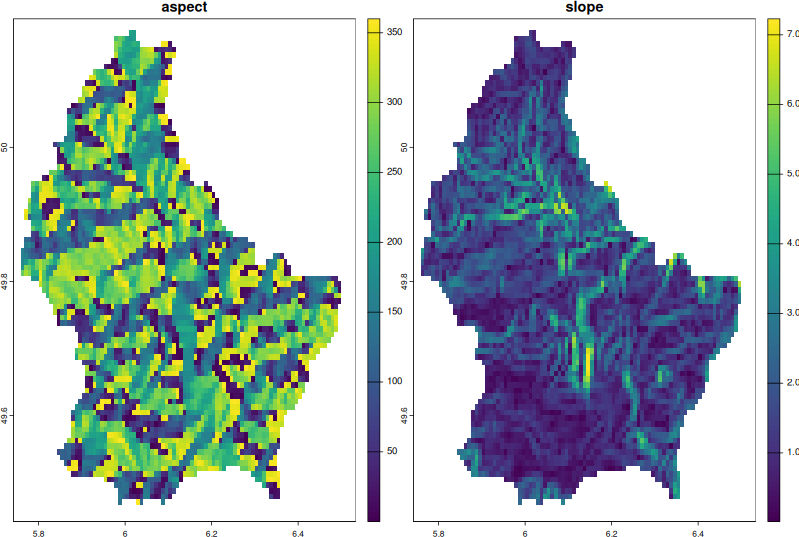

In [ ]:
writeRaster(grass_maps, "grass_maps.tif", overwrite=TRUE)

Alternatively, we can use GRASS exporting tools like
[r.out.gdal](https://grass.osgeo.org/grass-stable/manuals/r.out.gdal.html)
and
[v.out.ogr](https://grass.osgeo.org/grass-stable/manuals/v.out.ogr.html),
to directly save our outputs into common raster or vector formats,
respectively.

In [ ]:
execGRASS("r.out.gdal", input="slope", output="slope.tif", format="GTiff", flags="overwrite")

### B. Use R tools within GRASS workflows

Let’s see an example for the case when we do our geospatial data
processing within GRASS and hence have all the spatial data organized
within GRASS projects but we need to run some statistical analysis,
modelling, prediction or visualization in R.

In [ ]:
library(rgrass)

We start GRASS from within R or RStudio using the `initGRASS()`
function. Since we want to start GRASS in a specific project and mapset,
we need to specify them.

In [ ]:
# Start GRASS from R
initGRASS(gisDbase = path.expand("~/grassdata/"),
          location = "nc_basic_spm_grass7",
          mapset = "PERMANENT",
          override = TRUE,
          remove_GISRC = TRUE)

We can now list and read our GRASS raster and vector maps into R and do
our statistical analysis, modelling and/or visualizations using other R
packages. Here, we will demonstrate the use of all the main *rgrass*
functions mentioned above.

Let’s then list our GRASS raster and vector maps:

In [ ]:
# List GRASS raster maps
execGRASS("g.list", type="raster")

In [ ]:
# List GRASS vector maps
execGRASS("g.list", type="vector")

The resulting map lists could be saved in an R object that we can subset
later in case we want to import several but not all raster maps, for
example. Let’s see how to do that.

In [ ]:
# Save map list in an object
rast_list <- execGRASS("g.list", type="raster")

# Retrieve only the map list from standard output
rast_list <- attributes(rast_list)$resOut

# Import elevation and landuse
to_import <- c("elevation", "landuse") # optionally, by position: rast_list[c(3,7)]

maplist <- list()
for (i in to_import) {
  maplist[[i]] <- read_RAST(i)
}

maplist

Remember that raster objects will always be exported from GRASS
following the *computational region settings*. So, bear that in mind
when reading into R which will hold them in memory. Vectors however will
be exported in their full extent.

Let’s load the *terra* library to quickly display our recently imported
raster maps:

In [ ]:
library(terra)
plot(maplist$elevation)

Optionally, we could stack our two `SpatRaster` objects together and
plot them together:

In [ ]:
rstack <- rast(maplist)
plot(rstack)

Let’s create a boxplot of elevation per land class.

In [ ]:
boxplot(rstack$elevation, rstack$landuse, maxcell=50000)

Let’s import a vector map, too, and explore its attributes.

In [ ]:
census <- read_VECT("census")
head(census)

In [ ]:
summary(census$TOTAL_POP)

In [ ]:
plot(census, "P25_TO_34", type="interval", breaks=5, plg=list(x="topright"))

Let’s do some interactive visualization with `mapview`.

In [ ]:
library(mapview)
mapview(rstack$elevation) + census

We highly recommend you to check the
[tmap](https://r-tmap.github.io/tmap/) package to make really appealing
and publication ready maps.

To exemplify the use of `write_*` functions, let’s do a simple operation
with the *landuse* raster map. We will apply a custom function that
makes NULL all values less than 4.

In [ ]:
result <- app(rstack$landuse, fun=function(x){ x[x < 4] <- NA; return(x)} )
plot(result)

To use this new raster in GRASS, for example as an input to a GRASS
tool, we need to call `write_RAST` function:

In [ ]:
write_RAST(result, "result_from_R", overwrite = TRUE)

The new raster is now written as a GRASS raster and can be listed:

In [ ]:
execGRASS("g.list", parameters = list(type="raster", pattern="result*"))

Finally, there is yet another way in which you can use GRASS and R
together, and it involves calling R from the GRASS terminal. In this
way, *rgrass* will read all GRASS session environmental variables, and
you won’t need to use `initGRASS()`. It goes more or less like this:

1.  Open GRASS
2.  Type `R` or `rstudio &` in the GRASS terminal
3.  Load `rgrass` library with `library(rgrass)`
4.  Use `read_VECT()`, `read_RAST()` to read data from GRASS into R
5.  Do your analysis or plotting in R
6.  Write data (back) to GRASS database with `write_VECT()` and
    `write_RAST()`
7.  Quit R `quit()` and get back to GRASS terminal.

<!-- -->

    Starting GRASS GIS...

              __________  ___   __________    _______________
             / ____/ __ \/   | / ___/ ___/   / ____/  _/ ___/
            / / __/ /_/ / /| | \__ \\_  \   / / __ / / \__ \
           / /_/ / _, _/ ___ |___/ /__/ /  / /_/ // / ___/ /
           \____/_/ |_/_/  |_/____/____/   \____/___//____/

    Welcome to GRASS GIS 8.4.0
    GRASS GIS homepage:                      https://grass.osgeo.org
    This version running through:            Bash Shell (/bin/bash)
    Help is available with the command:      g.manual -i
    See the licence terms with:              g.version -c
    See citation options with:               g.version -x
    If required, restart the GUI with:       g.gui wxpython
    When ready to quit enter:                exit

    Launching <wxpython> GUI in the background, please wait...
    [Raster MASK present]
    GRASS nc_basic_spm_grass7/PERMANENT:~ > R

    R version 4.3.1 (2023-06-16) -- "Beagle Scouts"
    Copyright (C) 2023 The R Foundation for Statistical Computing
    Platform: x86_64-pc-linux-gnu (64-bit)

    R is free software and comes with ABSOLUTELY NO WARRANTY.
    You are welcome to redistribute it under certain conditions.
    Type 'license()' or 'licence()' for distribution details.

      Natural language support but running in an English locale

    R is a collaborative project with many contributors.
    Type 'contributors()' for more information and
    'citation()' on how to cite R or R packages in publications.

    Type 'demo()' for some demos, 'help()' for on-line help, or
    'help.start()' for an HTML browser interface to help.
    Type 'q()' to quit R.

    > library(rgrass)
    GRASS GIS interface loaded with GRASS version: GRASS 8.4.0 (2024)
    and location: nc_basic_spm_grass7
    > 

**Enjoy!**

## References

-   Bivand R (2024). *rgrass: Interface Between ‘GRASS’ Geographical
    Information System and ‘R’*. R package version 0.4-1,
    <https://CRAN.R-project.org/package=rgrass>.

------------------------------------------------------------------------

The development of this tutorial was funded by the US [National Science
Foundation (NSF)](https://www.nsf.gov/), award
[2303651](https://www.nsf.gov/awardsearch/showAward?AWD_ID=2303651).